In [1]:
import os
import pandas as pd

In [2]:
fns = os.listdir('../processed_data/adj_expression/')

In [3]:
with open('../processed_data/model_genes.txt', 'rb') as reader:
    selected_genes = set([s.strip() for s in reader.readlines()])

In [4]:
f = fns[0]
tissue = f.split('-')[0]
df_exp = pd.read_csv('../processed_data/adj_expression/' + f, index_col=0, nrows = 5)    
id2gene = [str(s) for s in df_exp.columns if s.split('.')[0] in selected_genes]
assert(len(id2gene) == len(selected_genes))

In [5]:
len(id2gene)

11890

In [6]:
data = []
id2tissue = []
for i, f in enumerate(fns):
    tissue = f.split('-')[0]
    df_exp = pd.read_csv('../processed_data/adj_expression/' + f, index_col=0)
    df_exp = df_exp[id2gene]
    data.append(df_exp.values)
    id2tissue += [tissue] * df_exp.shape[0]

In [7]:
len(id2tissue)

7051

In [8]:
import numpy as np
data = np.vstack(data)

In [9]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf


In [10]:
def DNN(x, theta_mat, is_train, scope = 'linear', reuse = tf.AUTO_REUSE):
    h_in = x 
    with tf.variable_scope(scope, reuse=reuse):
        for i, n_node in enumerate(theta_mat):
            
            #
            if (i > 0) and ((i+1) != len(theta_mat)):
                h_out = tf.layers.dense(h_in, n_node, name = 'h%02d/dense' % i, use_bias=False)
                h_in = h_out
                h_in = tf.layers.batch_normalization(h_in, training=is_train, name = 'h%02d/batch_norm' % i)
            else:
                h_out = tf.layers.dense(h_in, n_node, name = 'h%02d/dense' % i)
                h_in = h_out
                #h_in = tf.layers.dropout(h_in, rate=0.1, training=is_train)
            #h_in = tf.nn.relu(h_in) 
            h_in = tf.nn.tanh(h_in)   
    return h_out

In [11]:
num_gene = len(id2gene)

In [12]:
data.shape

(7051, 11890)

In [13]:
num_sample = data.shape[0]

ind_train = np.array([i for i in range(num_sample) if i % 20 != 0])
ind_test = np.array([i for i in range(num_sample) if i % 20 == 0])

train_data = data[ind_train, :].astype('float32')
test_data = data[ind_test, :].astype('float32')

num_sample = train_data.shape[0]

In [44]:
beta1 = 0.9
batch_size = 512

with tf.device("/gpu:0"):
    tf.reset_default_graph()
    
    ##========================= define inputs ===========================##
    is_training = tf.placeholder(tf.bool, name = 'is_training')
    l1_penalty = tf.placeholder(tf.float32, name = 'l1_penalty')
    
    inputs = tf.placeholder(tf.float32, [None, num_gene], 
                            name='inputs')
    
    ## net for inference
    theta_mat = [512, num_gene]
    logit_rec = DNN(inputs, theta_mat, False, scope = 'AE', reuse = False)
    rec_loss_l2 = tf.reduce_mean(tf.square(logit_rec - inputs))
    
    ## net for training, data loaded on GPU to save computation
    inputs_train0 = tf.constant(train_data.astype('float32'), name = 'input_training')
    
    train_dataset = tf.data.Dataset.from_tensor_slices((inputs_train0)).shuffle(buffer_size=1000).batch(batch_size)
    
    iterator = train_dataset.make_initializable_iterator()
    
    inputs_batch = iterator.get_next()
    
    inputs_train = inputs_batch + tf.random.normal(tf.shape(inputs_batch), mean=0.0, stddev=.5)

    logit_rec_train = DNN(inputs_train, theta_mat, is_training, scope = 'AE', reuse = True)

    rec_loss_l2_train = tf.reduce_mean(tf.square(logit_rec_train - inputs_batch))
    d_loss = rec_loss_l2_train
    #'''
    for v in tf.contrib.framework.get_variables_to_restore(include=['AE/']): 
        if 'dense' not in v.name:
             continue
        
        print v.name
        #d_loss += l1_penalty * (tf.reduce_mean(tf.abs(v)) + tf.reduce_mean(tf.square(v))) * 0.5
        #d_loss += l1_penalty * tf.reduce_mean(tf.square(v))
        d_loss += l1_penalty * tf.reduce_mean(tf.abs(v))
    #'''
    
    d_lrd = tf.placeholder(tf.float32, name = 'd_lrd')
    
    d_optim = tf.train.AdamOptimizer(d_lrd, beta1=beta1)  
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        d_train_op = d_optim.minimize(d_loss)


AE/h00/dense/kernel:0
AE/h00/dense/bias:0
AE/h01/dense/kernel:0
AE/h01/dense/bias:0


In [39]:
inputs_batch

<tf.Tensor 'IteratorGetNext:0' shape=(?, 11890) dtype=float32>

In [45]:
sess = tf.Session()

In [46]:
sess.run(tf.global_variables_initializer())

In [63]:
iter_counter = 0
errD, errG, D_count, G_count = 0.0, 0.0, 0.0, 0.0

num_batch = num_sample

for epoch in range(1000):
    lrd = 0.001 / np.sqrt(epoch * 0.05 + 1)
    idx = 0
    l1_val = 100.
    sess.run(iterator.initializer)
    while True:
        try:
            

            # updates the discriminator
            feed_dict={is_training:True,
                       l1_penalty: l1_val,
                       #noise_level: 0.05, 
                       d_lrd: lrd,
                        }

            val, _ = sess.run([rec_loss_l2_train, d_train_op], feed_dict=feed_dict)

            errD += val
            D_count += 1.0        
        
        ## end of dataset   
        except tf.errors.OutOfRangeError:
            errD = errD / D_count

            feed_dict={inputs: test_data, 
                   is_training:False,
                   }            

            test_errD1 = sess.run(rec_loss_l2, feed_dict=feed_dict)


            msr = "iter: %4d, train_loss: %.4f, test_loss: %.4f" \
                % (idx, errD,test_errD1)
            print(msr)
            errD, errG, D_count, G_count = 0.0, 0.0, 0.0, 0.0

            iter_counter += 1
        
            
            break
            

iter:    0, train_loss: 0.7496, test_loss: 0.7963
iter:    0, train_loss: 0.8184, test_loss: 0.8407
iter:    0, train_loss: 0.8596, test_loss: 0.8660
iter:    0, train_loss: 0.8813, test_loss: 0.8818
iter:    0, train_loss: 0.8967, test_loss: 0.8913
iter:    0, train_loss: 0.9057, test_loss: 0.8970
iter:    0, train_loss: 0.9075, test_loss: 0.9005
iter:    0, train_loss: 0.9118, test_loss: 0.9027
iter:    0, train_loss: 0.9115, test_loss: 0.9040
iter:    0, train_loss: 0.9148, test_loss: 0.9048
iter:    0, train_loss: 0.9169, test_loss: 0.9052
iter:    0, train_loss: 0.9151, test_loss: 0.9054
iter:    0, train_loss: 0.9185, test_loss: 0.9053
iter:    0, train_loss: 0.9160, test_loss: 0.9051
iter:    0, train_loss: 0.9135, test_loss: 0.9049
iter:    0, train_loss: 0.9151, test_loss: 0.9047
iter:    0, train_loss: 0.9156, test_loss: 0.9043
iter:    0, train_loss: 0.9179, test_loss: 0.9039
iter:    0, train_loss: 0.9163, test_loss: 0.9035
iter:    0, train_loss: 0.9147, test_loss: 0.9031


KeyboardInterrupt: 

In [49]:
w0 = tf.contrib.framework.get_variables_to_restore(include=['AE/h00/dense'])[0]

In [64]:
w0_val = sess.run(w0)

In [65]:
np.sum(np.abs(w0_val) < 5e-7) / float(w0_val.size)

0.005677532327586207

In [66]:
np.mean(np.abs(w0_val))

0.0001747833

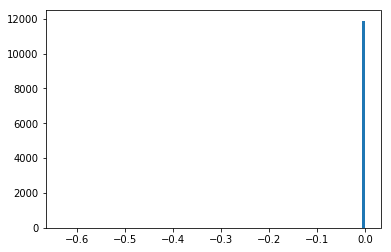

In [67]:
import matplotlib.pyplot as plt
% matplotlib inline

plt.hist(w0_val[:, 1], bins = 100)
plt.show()

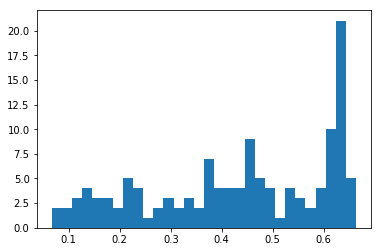

In [68]:
plt.hist([np.max(np.abs(w0_val[:, i])) for i in range(128)], bins = 30)
plt.show()

In [69]:
np.abs(w0_val[:, 0]).max()

0.18704912

In [70]:
from statsmodels import robust

In [71]:
for i in range(100):
    thre = (0.01 * np.abs(w0_val[:, i])).max()
    #thre = 3.0 * w0_val[:, i].std()
    #thre = 1.8 * robust.mad(w0_val[:, i])
    #thre = 1e-5
    print i, np.sum(np.abs(w0_val[:, i]) > thre ), thre, np.max(np.abs(w0_val[:, i]))

0 93 0.0018704912 0.18704912
1 1 0.006331587 0.63315874
2 1 0.0063246437 0.6324644
3 1 0.006188446 0.6188446
4 1 0.006408462 0.6408462
5 1 0.0061413883 0.61413884
6 2 0.0049717063 0.49717066
7 8 0.0024855162 0.24855162
8 78 0.0018491157 0.18491158
9 12 0.0037821908 0.3782191
10 1 0.006458727 0.6458727
11 52 0.0014362027 0.14362027
12 1 0.0064762663 0.64762664
13 65 0.0016077126 0.16077127
14 90 0.0011680465 0.11680465
15 9 0.0029087842 0.29087842
16 67 0.0015014791 0.15014791
17 2 0.004235092 0.42350924
18 3 0.0046070646 0.46070647
19 3 0.0046535996 0.46536
20 23 0.0030993468 0.30993468
21 3 0.0052465466 0.5246547
22 2 0.006300131 0.6300131
23 2 0.004789571 0.4789571
24 16 0.00291469 0.291469
25 1 0.0062448294 0.6244829
26 6 0.004480366 0.4480366
27 1 0.0063684843 0.63684845
28 13 0.0031892054 0.31892055
29 3 0.0038256194 0.38256195
30 38 0.0019689838 0.19689839
31 2 0.006194835 0.61948353
32 4 0.0054671215 0.54671216
33 28 0.0022463775 0.22463776
34 4 0.0035827958 0.3582796
35 29 0.00

/data1/users/hclee/hclee/python2/local/lib/python2.7/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


RuntimeError: maximum recursion depth exceeded while getting the str of an object

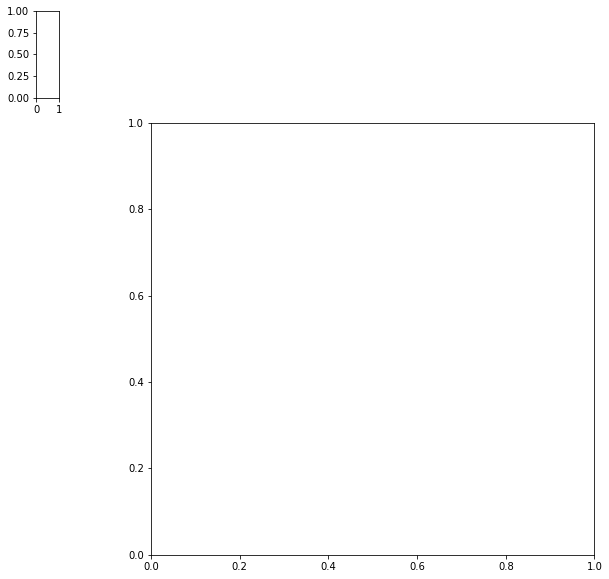

In [72]:
import seaborn.apionly as sns

sns.clustermap(w0_val, cmap = 'RdBu_r')
plt.show()

In [ ]:
sns.clustermap(test_data.dot(w0_val), cmap = 'RdBu_r')
plt.show()

In [73]:
import pickle
with open('ensembl2genename.p', 'rb') as reader:
    gid2gn = pickle.load(reader)

In [74]:
for i in np.where(np.abs(w0_val[:, 5]) > (1.8 * robust.mad(w0_val[:, 5]) ))[0]:
    gid = id2gene[i].split('.')[0]
    if gid in gid2gn:
        print gid2gn[gid]
    else:
        print gid

PANK4
LRRC47
RNF207
RPL22
UBIAD1
FBXO2
AGTRAP
KIAA2013
EFHD2
CASP9
DDI2
EMC1
TMCO4
USP48
ZBTB40
ZNF436-AS1
NIPAL3
PAQR7
CD52
ARID1A
TRNP1
PHACTR4
SRSF4
PTPRU
SNRNP40
FABP3
SERINC2
COL16A1
HDAC1
FAM229A
PHC2
AGO4
AGO1
ADPRHL2
TRAPPC3
LSM10
SNIP1
INPP5B
HEYL
OXCT2
CITED4
ERMAP
TESK2
MMACHC
PIK3R3
UQCRH
BEND5
TMEM59
TCEANC2
MRPL37
MIER1
TYW3
IFI44
ODF2L
EVI5
BCAR3
LRRC39
DBT
DPH5
CELSR2
PSRC1
GNAI3
GSTM2
GSTM1
GSTM5
PTPN22
OLFML3
CSDE1
CD58
TTF2
MAN1A2
FAM46C
BCL9
ENSG00000183558
ENSG00000163113
PLEKHO1
MCL1
BNIPL
RFX5
SELENBP1
POGZ
S100A16
CKS1B
SLC50A1
GON4L
ARHGEF2
LAMTOR2
AIM2
ACKR1
PEX19
KLHDC9
FCRLB
DUSP12
UHMK1
RGS5
PRRX1
SUCO
RASAL2
IER5
DDX59
TIMM17A
ADORA1
PRELP
ATP2B4
TMCC2
ENSG00000163486
ENSG00000136653
EIF2D
LAMB3
ATF3
TMEM63A
ARV1
MTR
SDCCAG8
SMYD3
KLF6
ATP5C1
USP6NL
PHYH
PTER
HACD1
APBB1IP
BAMBI
MAP3K8
PARD3
NAMPTP1
CSGALNACT2
FAM21C
ARHGAP22
WDFY4
ENSG00000138297
IPMK
DNAJC12
C10orf35
DNAJC9
MSS51
SAMD8
ZNF503
C10orf11
TMEM254
PLAC9
SNCG
PANK1
FRA10AC1
NOC3L
TCTN3
UBTD1
L

In [ ]:
for i in np.where(np.abs(w0_val[:, 138]) > (3.0 * w0_val[:, 138].std()))[0]:
    gid = id2gene[i].split('.')[0]
    if gid in gid2gn:
        print gid2gn[gid]
    else:
        print gid

In [ ]:
gid2gn

In [198]:
feed_dict={inputs: test_data, 
           is_training:False,
           l1_penalty: l1_val,
           #noise_level: 0.05, 
           d_lrd: lrd,
            }

rec_val = sess.run(logit_rec, feed_dict=feed_dict)

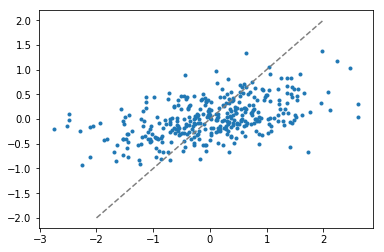

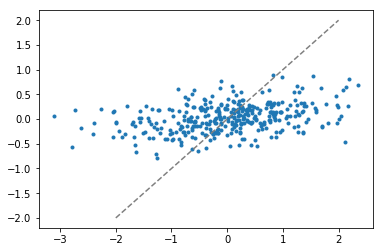

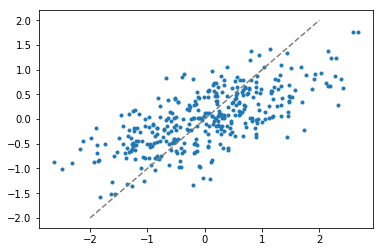

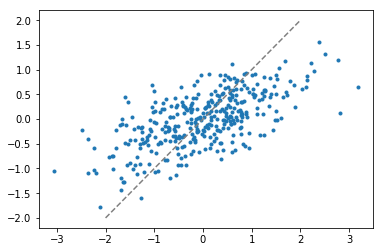

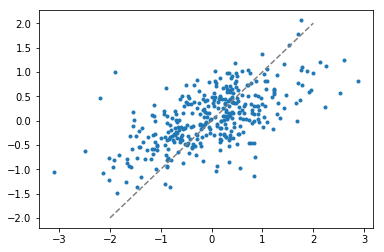

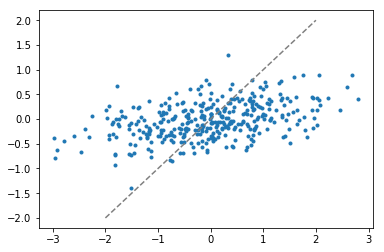

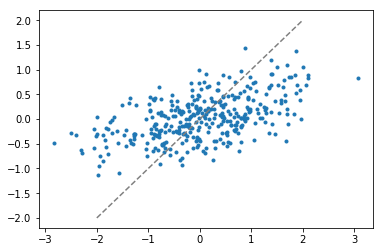

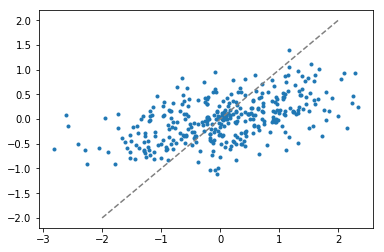

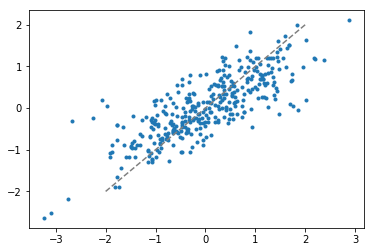

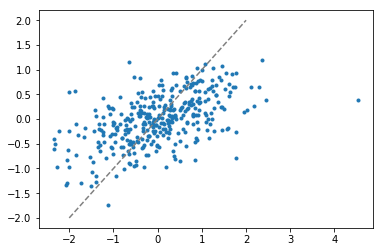

In [199]:
for i in range(0, 100, 10):
    plt.plot(test_data[:, i], rec_val[:, i], '.')
    plt.plot([-2.0, 2.0], [-2.0, 2.0], '--', color = 'gray')
    plt.show()

In [ ]:
from sklearn.decomposition import PCA
clf = PCA(n_components = 128)

In [ ]:
clf.fit(train_data)

In [ ]:
clf.explained_variance_ratio_.sum()

In [ ]:
test_rec = clf.inverse_transform(clf.transform(test_data))

In [ ]:
np.mean((test_rec - test_data) ** 2)

In [ ]:
train_rec = clf.inverse_transform(clf.transform(train_data))
np.mean((train_rec - train_data) ** 2)